# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

c:\Users\victor.briones\Documents\python_virtual_enviroments\exploratory_data_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Librerías cargadas correctamente.


In [2]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
anio = 2026
name_file = 'anual_ecobici_plus' 
nombre_archivo = f'../data/data_forecast_{anio}/data_forecast_{anio}_silver/numero_membresia_{name_file}_limpio.csv'
print(f"Cargando el archivo: {nombre_archivo}")  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Cargando el archivo: ../data/data_forecast_2026/data_forecast_2026_silver/numero_membresia_anual_ecobici_plus_limpio.csv
Rango de fechas: 2024-05-03 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
0,16,13574.9,2024-05-03,16.0
1,12,10788.0,2024-05-04,12.0
2,19,17081.0,2024-05-05,19.0
3,12,10788.0,2024-05-06,12.0
4,9,8091.0,2024-05-07,9.0


In [3]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
count,574.000000,574.000000,574,574.000000
mean,8.362369,7546.780383,2025-02-14 03:50:48.083623680,7.641115
min,1.000000,898.990000,2024-05-03 00:00:00,1.000000
25%,4.000000,3736.000000,2024-09-23 06:00:00,4.000000
50%,7.000000,6293.000000,2025-02-13 12:00:00,7.000000
75%,11.000000,9889.000000,2025-07-07 18:00:00,10.000000
max,34.000000,30565.990000,2025-11-30 00:00:00,21.000000
std,5.660652,5070.291570,NaN,4.401743


Filtro para obtener muestra de datos

In [4]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'cantidad_Vendida_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [5]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """
df['cap'] = 25

# 2. Configurar el modelo con crecimiento logístico
m = Prophet(
            changepoint_prior_scale=0.08,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
            seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
            daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
            #########
            growth='logistic', 
            seasonality_mode='multiplicative',
            yearly_seasonality=True)

m.add_country_holidays(country_name='MX')
m.fit(df)


17:15:17 - cmdstanpy - INFO - Chain [1] start processing
17:15:17 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [6]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365)
future['cap'] = 25

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

            ds  cap
934 2026-11-26   25
935 2026-11-27   25
936 2026-11-28   25
937 2026-11-29   25
938 2026-11-30   25


Paso 5: Realizar la Predicción (Forecast)

In [7]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds      yhat  yhat_lower  yhat_upper
934 2026-11-26  2.939984   -1.369597    7.176946
935 2026-11-27  2.988467   -1.562551    7.164441
936 2026-11-28  3.490666   -0.742248    8.157646
937 2026-11-29  4.121020   -0.414981    8.395927
938 2026-11-30  2.814892   -1.438482    7.124281


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

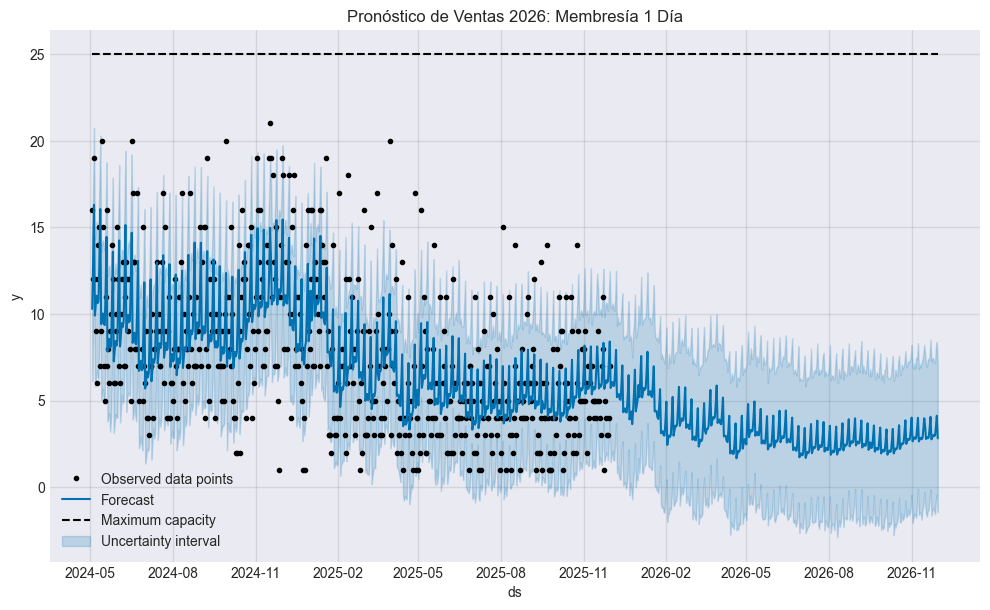

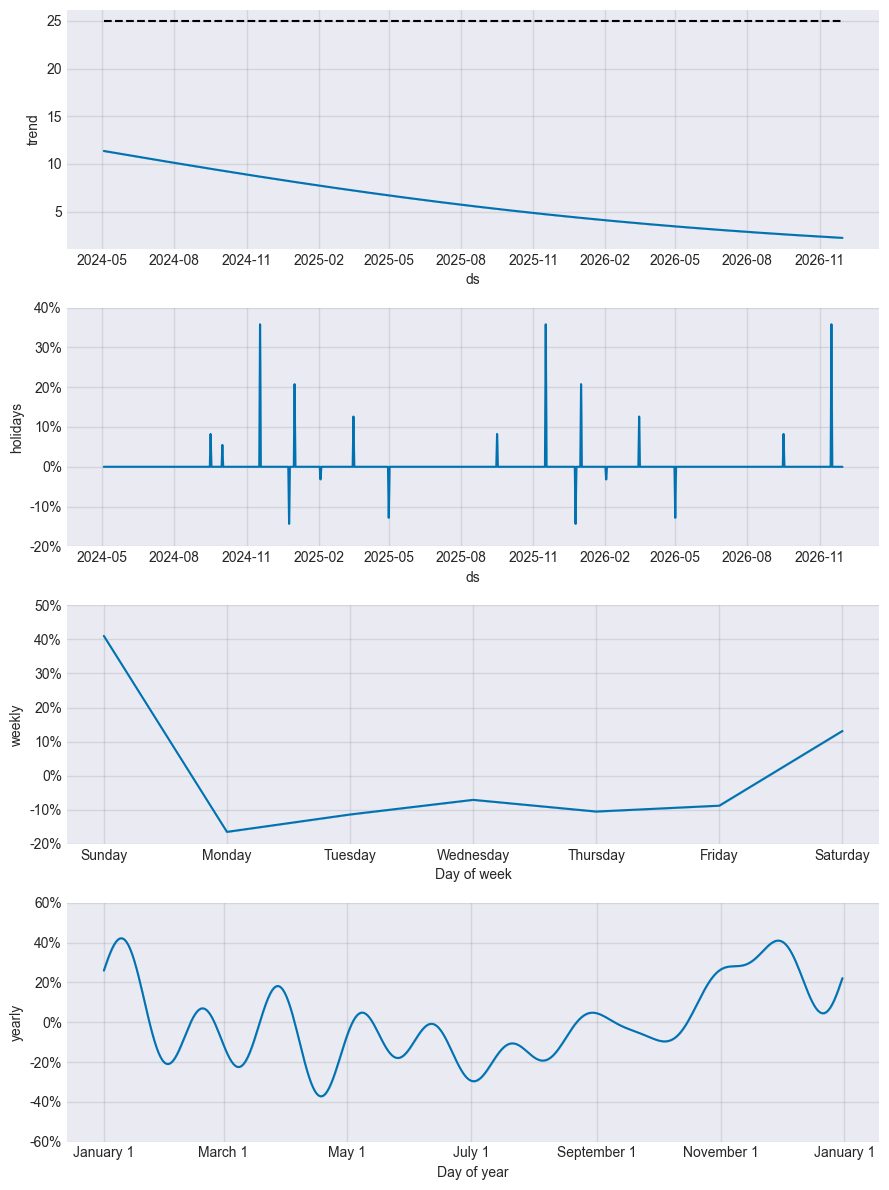

In [8]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas 2026: Membresía 1 Día")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [9]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(0).reset_index()
print(monthly_sales)

      month   yhat  yhat_lower  yhat_upper
0   2024-05  301.0       177.0       425.0
1   2024-06  293.0       163.0       421.0
2   2024-07  258.0       124.0       392.0
3   2024-08  282.0       149.0       417.0
4   2024-09  281.0       151.0       412.0
5   2024-10  292.0       161.0       425.0
6   2024-11  349.0       219.0       479.0
7   2024-12  307.0       173.0       440.0
8   2025-01  293.0       158.0       426.0
9   2025-02  202.0        81.0       323.0
10  2025-03  218.0        84.0       351.0
11  2025-04  165.0        36.0       294.0
12  2025-05  184.0        55.0       314.0
13  2025-06  168.0        39.0       297.0
14  2025-07  143.0        13.0       273.0
15  2025-08  162.0        30.0       295.0
16  2025-09  154.0        25.0       282.0
17  2025-10  155.0        25.0       284.0
18  2025-11  193.0        62.0       321.0
19  2025-12  164.0        30.0       298.0
20  2026-01  158.0        24.0       291.0
21  2026-02  107.0       -14.0       227.0
22  2026-03

In [10]:
monthly_sales.to_csv(f"../data/data_forecast_{anio}/data_forecast_{anio}_gold/forecast_numero_{name_file}_{anio}_monthly.csv")

In [11]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.